# How to implement testing for Covid-19

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sid.config import INDEX_NAMES
from sid import simulate

## The stages

### Demand models

In [2]:
def demand_test_if_experience_symptoms(states, params):
    """Demand test if person experiences symptoms.
    
    This demand model assumes that individuals request a test for a
    Covid-19 infection if they experience symptoms with a probability of 1.
    
    We select individuals who just got symptomatic by selecting the individuals where
    the countdown for getting symptoms has reached 0, is exhausted.
    
    Args:
        states (pandas.DataFrame): The states of the individuals.
        params (pandas.DataFrame): A DataFrame with parameters.
        
    Returns:
        demand_probability (numpy.ndarray, pandas.Series): An array or a series
            which contains the probability for each individual demanding a test.
    
    """
    s = states.symptomatic.copy()
    return s

In [3]:
testing_demand_models = {
    "symptoms": {
        "model": demand_test_if_experience_symptoms,
        # "loc": ...,
    }
}

### Allocation models

In [4]:
def allocate_tests(allocated_tests, demands_test, states, params):
    """Allocate tests to individuals who demand a test.
    
    For simplicity, we assume that everyone who demands a test
    receives one.
    
    Args:
        demands_test (pandas.Series): A series with boolean entries
            where ``True`` indicates individuals asking for a test.
        states (pandas.DataFrame): The states of the individuals.
        params (pandas.DataFrame): A DataFrame with parameters.
    
    Returns:
        received_test (numpy.ndarray, pandas.Series): An array or a
            series which indicates which individuals received a test.
    
    """
    n_available_tests = int(params.loc[("testing", "allocation", "available_tests"), "value"])
    locs = demands_test[demands_test].iloc[:n_available_tests].index
    
    received_test = pd.Series(index=states.index, data=False)
    received_test.loc[locs] = True
    
    return received_test

In [5]:
testing_allocation_models = {
    "direct_allocation": {
        "model": allocate_tests,
        # "loc": ...,
    }
}

### Processing models

In [6]:
def process_tests(to_be_processed_tests, states, params):
    """Process tests.
    
    For simplicity, we assume that all tests are processed immediately, without
    further delay.
    
    Args:
        to_be_processed_tests (pandas.Series): A series with boolean entries
            indicating whether the test of an individual is still waiting
            to be processed.
        states (pandas.DataFrame): The states of the individuals.
        params (pandas.DataFrame): A DataFrame with parameters.
    
    Returns:
        started_processing (numpy.ndarray, pandas.Series): An array or series
            with boolean entries indicating which tests started to be processed.    
    
    """
    n_available_capacity = int(params.loc[("testing", "processing", "available_capacity"), "value"])
    locs = states.loc[states.pending_test].iloc[:n_available_capacity].index
    
    to_be_processed_tests = pd.Series(index=states.index, data=False)
    to_be_processed_tests.loc[locs] = True
    
    return to_be_processed_tests

In [7]:
testing_processing_models = {
    "direct_processing": {
        "model": process_tests,
        # "loc": ...,
    }
}

## Prepare the rest

### Initial states

In [8]:
available_ages = [
        "0-9",
        "10-19",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60-69",
        "70-79",
        "80-100",
    ]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions})
initial_states = initial_states.astype("category")
initial_states["id"] = initial_states.index

### Initial infections

In [9]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(100, random_state=0).index
initial_infections.loc[infected_individuals] = True

### Contact models

In [10]:
def meet_distant(states, params):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    contacts = pd.Series(contacts, index=states.index)
    
    # Everyone who received a positive test result will stay home for 14 days
    # after the infection.
    condition = states.knows & states.immune & states.cd_immune_false.ge(986)
    contacts.loc[condition] = 0
    
    return pd.Series(contacts, index=states.index)


def meet_close(states, params):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

### Parameters

In [11]:
inf_params = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)
assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)
disease_params = pd.read_csv("../../../src/sid/covid_epi_params.csv", index_col=INDEX_NAMES)
params = pd.concat([disease_params, inf_params, assort_probs])

In [12]:
params.loc[("testing", "allocation", "available_tests"), "value"] = 30
params.loc[('testing', 'processing', 'available_capacity'), "value"] = 20

C:\tools\miniconda3\envs\sid\lib\site-packages\IPython\core\interactiveshell.py:2876: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


## Run the simulation

In [13]:
df_without_testing = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": 20},  
    seed=0,
)

In [14]:
df_with_testing = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": 20},
    testing_demand_models=testing_demand_models,
    testing_allocation_models=testing_allocation_models,
    testing_processing_models=testing_processing_models,    
    seed=0,
)

In [15]:
df = df_without_testing.compute()

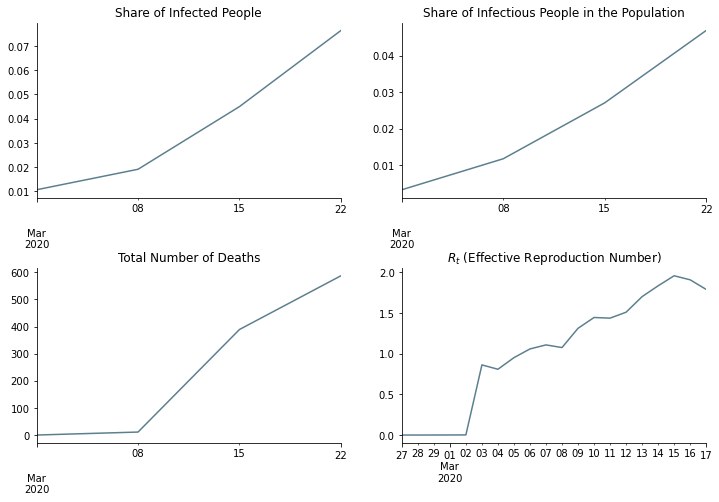

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("W", on="date")["ever_infected"].mean().plot(ax=axs[0], color="#5c7f8e")
df.resample("W", on="date")["infectious"].mean().plot(ax=axs[1], color="#5c7f8e")
df.resample("W", on="date")["dead"].sum().cumsum().plot(ax=axs[2], color="#5c7f8e")
infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].resample("D", on="date")[
    "n_has_infected"
].mean().plot(ax=axs[3], color="#5c7f8e")

for ax in axs:
    ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")

plt.show()

In [17]:
df = df_with_testing.compute()

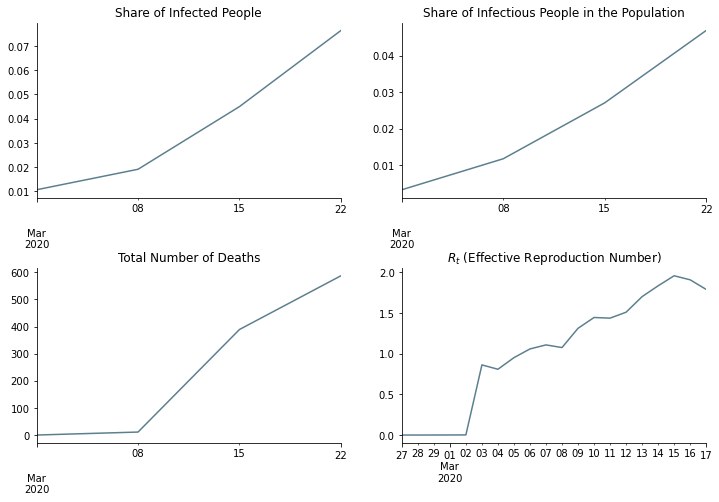

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("W", on="date")["ever_infected"].mean().plot(ax=axs[0], color="#5c7f8e")
df.resample("W", on="date")["infectious"].mean().plot(ax=axs[1], color="#5c7f8e")
df.resample("W", on="date")["dead"].sum().cumsum().plot(ax=axs[2], color="#5c7f8e")
infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].resample("D", on="date")[
    "n_has_infected"
].mean().plot(ax=axs[3], color="#5c7f8e")

for ax in axs:
    ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")

plt.show()

In [24]:
df_with_testing.infectious.sum().compute()

3789

In [25]:
df_without_testing.infectious.sum().compute()

3789